# Sentiment Analysis on Amazon Customer Reviews

For this project, we’ll be using the Amazon customer reviews dataset which can be found on [Kaggle](https://www.kaggle.com/bittlingmayer/amazonreviews). The dataset contains a total of 4 million reviews with each review labelled to be of either positive or negative sentiment. I will only be using 100k reviews in this implementation to speed things up, however, feel free to run it yourself with the entire dataset if you have the time and computing capacity. You can run the codes on GPU to speed up the training process significantly. You can also use [My Notebook on Google Colab](https://colab.research.google.com/drive/1pFduf8iVOuFGm9-nkPxQEm3GniPhEBzw?usp=sharing) if your hardware is not powerful enough.

Our goal at the of this implementation will be to create an LSTM model that can accurately classify and distinguish the sentiment of a review. To do so, we'll have to start with some data-preprocessing, defining and training the model, followed by assessing the model.

For our data pre-processing steps, we'll be using *regex*, *numpy* and the *NLTK (Natural Language Toolkit)* library for some simple NLP helper functions. As the data is compressed in the *bz2* format, we'll use the Python *bz2* module to read the data. The process flow of our implementation looks like this.

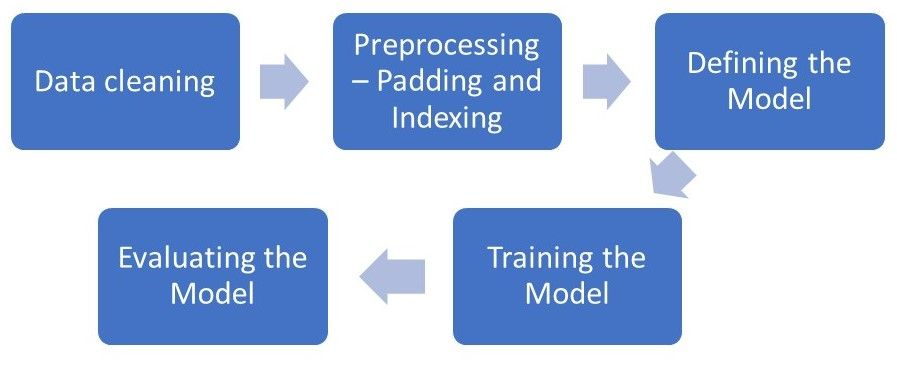

In [1]:
import bz2
from collections import Counter
import re
import nltk
import numpy as np
import random
from tqdm.notebook import tqdm

random.seed(8)

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/masoud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_file_all = bz2.BZ2File("./data/train.ft.txt.bz2").readlines()
test_file_all = bz2.BZ2File("./data/test.ft.txt.bz2").readlines()

In [3]:
print("Number of training reivews: " + str(len(train_file_all)))
print("Number of test reviews: " + str(len(test_file_all)))

Number of training reivews: 3600000
Number of test reviews: 400000


This dataset contains a total of 4 million reviews - 3.6 million training and 0.4 million testing. We won't be using the entire dataset to save time. However, if you have the computing power and capacity, go ahead and train the model on a larger portion of data.

In [4]:
num_train = (
    80000  # we're training on the 80000 randomly selected reviews in the dataset
)
num_test = 20000  # Using 20000 reviews from test set

train_file = [x.decode("utf-8") for x in random.sample(train_file_all, num_train)]
test_file = [x.decode("utf-8") for x in random.sample(test_file_all, num_test)]

The format of the sentences are as such:

In [5]:
print(train_file[0])

__label__2 Strong Like Bull!: I purchased this as a gift for my son. The bench is very sturdy and well made. If your looking for the right tool for the job, this is it!



In [6]:
del test_file_all, train_file_all

### Some pre-processing

Next, we'll have to extract out the labels from the sentences. The data is the format ```__label__1/2 <sentence>```, therefore we can easily split it accordingly. Positive sentiment labels are stored as 1 and negative are stored as 0.

We will also change all *url*s to a standard "<url\>" as the exact url is irrelevant to the sentiment in most cases.

In [7]:
# Extracting labels from sentences

train_labels = [0 if x.split(" ")[0] == "__label__1" else 1 for x in train_file]
train_sentences = [x.split(" ", 1)[1][:-1].lower() for x in train_file]


test_labels = [0 if x.split(" ")[0] == "__label__1" else 1 for x in test_file]
test_sentences = [x.split(" ", 1)[1][:-1].lower() for x in test_file]

# Some simple cleaning of data

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub("\d", "0", train_sentences[i])

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub("\d", "0", test_sentences[i])

# Modify URLs to <url>

for i in range(len(train_sentences)):
    if (
        "www." in train_sentences[i]
        or "http:" in train_sentences[i]
        or "https:" in train_sentences[i]
        or ".com" in train_sentences[i]
    ):
        train_sentences[i] = re.sub(
            r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i]
        )

for i in range(len(test_sentences)):
    if (
        "www." in test_sentences[i]
        or "http:" in test_sentences[i]
        or "https:" in test_sentences[i]
        or ".com" in test_sentences[i]
    ):
        test_sentences[i] = re.sub(
            r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i]
        )

After quickly cleaning the data, we will do tokenization of the sentences, which is a standard NLP task. 
Tokenization is the task of splitting a sentence into the individual tokens, which can be words or punctuation, etc.
There are many NLP libraries that are able to do this, such as *spaCy* or *Scikit-learn*, but we will be using *NLTK* here as it has one of the faster tokenizers.

The words will then be stored in a dictionary mapping the word to its number of appearances. These words will become our **vocabulary**.

In [8]:
train_labels[0], train_sentences[0]

(1,
 'strong like bull!: i purchased this as a gift for my son. the bench is very sturdy and well made. if your looking for the right tool for the job, this is it!')

In [9]:
# Dictionary that will map a word to the number of times it appeared in all the training sentences
words = Counter()

for i, sentence in enumerate(tqdm(train_sentences)):
    # The sentences will be stored as a list of words/tokens
    train_sentences[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        words.update([word.lower()])  # Converting all the words to lower case
        train_sentences[i].append(word)

  0%|          | 0/80000 [00:00<?, ?it/s]

In [10]:
print(train_sentences[0])

['strong', 'like', 'bull', '!', ':', 'i', 'purchased', 'this', 'as', 'a', 'gift', 'for', 'my', 'son', '.', 'the', 'bench', 'is', 'very', 'sturdy', 'and', 'well', 'made', '.', 'if', 'your', 'looking', 'for', 'the', 'right', 'tool', 'for', 'the', 'job', ',', 'this', 'is', 'it', '!']


In [11]:
print(words["stuning"])

1


To remove typos and words that likely don't exist, we'll remove all words from the vocab that only appear less than a `min_occurrence_threshold` throughout.
To account for **unknown** words and **padding**, we'll have to add them to our vocabulary as well. Each word in the vocabulary will then be assigned an integer index and thereafter mapped to this integer.

In [12]:
min_occurrence_threshold = 1
# Removing the words that only appear once
words = {k: v for k, v in words.items() if v > min_occurrence_threshold}
# Sorting the words according to the number of appearances, with the most common word being first
words = sorted(words, key=words.get, reverse=True)
# Adding padding and unknown to our vocabulary so that they will be assigned an index
words = ["_PAD", "_UNK"] + words
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o: i for i, o in enumerate(words)}
idx2word = {i: o for i, o in enumerate(words)}

In [13]:
idx2word[0], idx2word[1]

('_PAD', '_UNK')

With the mappings, we'll convert the words in the sentences to their corresponding indexes.

In [14]:
for i, sentence in enumerate(tqdm(train_sentences)):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_sentences[i] = [
        word2idx[word] if word in word2idx else 1 for word in sentence
    ]

  0%|          | 0/80000 [00:00<?, ?it/s]

In [15]:
for i, sentence in enumerate(tqdm(test_sentences)):
    # For test sentences, we have to tokenize the sentences as well
    test_sentences[i] = [
        word2idx[word.lower()] if word.lower() in word2idx else 1
        for word in nltk.word_tokenize(sentence)
    ]

  0%|          | 0/20000 [00:00<?, ?it/s]

In the last pre-processing step, we'll be padding the sentences with 0s and shortening the lengthy sentences so that the data can be trained in batches to speed things up.

In [16]:
train_sentences[10]

[2983,
 13,
 173,
 11,
 25,
 256,
 455,
 200,
 47,
 3,
 360,
 10,
 743,
 10,
 3,
 1546,
 4,
 9,
 12,
 13694,
 9270,
 21,
 3,
 750,
 4323,
 10,
 3,
 201,
 4,
 580,
 9485,
 4,
 580,
 1083,
 1,
 8,
 2274,
 136,
 5183,
 504,
 10,
 11,
 25,
 4,
 6,
 214,
 16,
 7,
 2066,
 4,
 4356,
 1945]

In [17]:
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length/ Pad from right
def pad_input(sentences, seq_len):
    features = np.zeros(
        (len(sentences), seq_len), dtype=int
    )  # instances * features (seq_len)
    for idx, review in enumerate(tqdm(sentences)):
        if len(review) != 0:
            features[idx, -len(review) :] = np.array(review)[:seq_len]
    return features

In [18]:
seq_len = 200  # The length that the sentences will be padded/shortened to

train_sentences = pad_input(train_sentences, seq_len)
test_sentences = pad_input(test_sentences, seq_len)

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [19]:
# Converting our labels into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

A padded sentence will look something like this, where 0 represents the padding: 

In [20]:
train_sentences[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

We can save the final result of our preprocessed data as Numpy arrays and load them later to save the time of all above preprocessing steps

In [21]:
np.save("./data/train_sentences.npy", train_sentences)
np.save("./data/test_sentences.npy", test_sentences)
np.save("./data/train_labels.npy", train_labels)
np.save("./data/test_labels.npy", test_labels)

Our dataset is already split into *training* and *testing* data. However, we still need a set of data for validation during training. Therefore, we will split our test data by half into a validation set and a testing set. A detailed explanation on dataset splits can be found [here](https://machinelearningmastery.com/difference-test-validation-datasets/).

In [22]:
split_frac = 0.5
split_id = int(split_frac * len(test_sentences))
val_sentences, test_sentences = test_sentences[:split_id], test_sentences[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [23]:
print(f"Val len: {val_sentences.shape}, Test len: {test_sentences.shape}")

Val len: (10000, 200), Test len: (10000, 200)


Next, this is the point where we’ll start working with the PyTorch library. We’ll first define the datasets from the sentences and labels, followed by loading them into a data loader. We set the batch size to 100. Please note that number of instances must be divisible by the `batch_size` in our implementations. This can be tweaked later according to our needs.

In [24]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

train_data = TensorDataset(
    torch.from_numpy(train_sentences), torch.from_numpy(train_labels)
)

val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))

test_data = TensorDataset(
    torch.from_numpy(test_sentences), torch.from_numpy(test_labels)
)

batch_size = 100

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [25]:
# free memory
del train_sentences, test_sentences

We can also check if we have any GPUs to speed up our training time by many folds.

In [26]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [27]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print(sample_x.shape, sample_y.shape)

torch.Size([100, 200]) torch.Size([100])


At this point, we will be defining the architecture of the model. At this stage, we can create Neural Networks that have deep layers or and large number of LSTM layers stacked on top of each other. However, a simple model such as the one below works quite well and requires much less training time. **We will be training our own word embeddings in the first layer before the sentences are fed into the LSTM layer.**

The final layer is a fully connected layer with a sigmoid function to classify whether the review is of positive/negative sentiment.

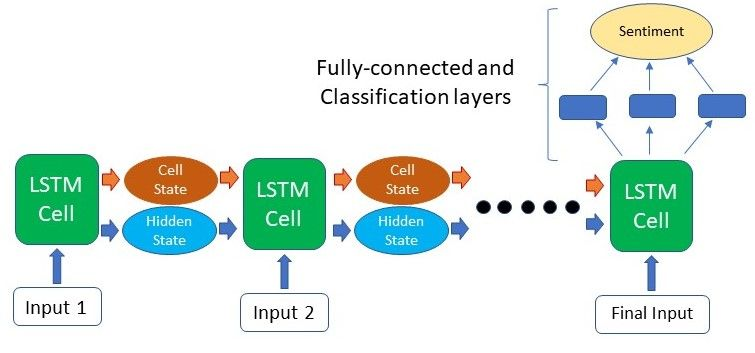

In [28]:
class SentimentNet(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size,
        embedding_dim,
        hidden_dim,
        n_layers,
        drop_prob=0.5,
    ):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        x = x.long()  # (100, 200)

        embeds = self.embedding(x)  # (100, 200, 400)

        # lstm_out: (100, 200, 512)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)  # (20000, 512)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)  # (20000, 1)
        out = out.view(batch_size, -1)  # (100, 200)
        # get last timestamp output of every instances in the batch
        out = out[:, -1]  # (100, 1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

Please note that we can actually load pre-trained word embeddings such as GloVe or fastText which can increase the model's accuracy and decrease training time.

With this, we can instantiate our model after defining the arguments. The output dimension will only be 1 as it only needs to output 1 or 0. The learning rate, loss function and optimizer are defined as well.

In [29]:
vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 512
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model)

SentimentNet(
  (embedding): Embedding(57231, 400)
  (lstm): LSTM(400, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [30]:
vocab_size

57231

In [31]:
lr = 0.005
# Binary Cross Entropy
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Finally, we can start training the model. For every 1000 steps, we’ll be checking the output of our model against the validation dataset and saving the model if it performed better than the previous time.
The `state_dict` is the model's weights in PyTorch and can be loaded into a model with the same architecture at a separate time or script altogether.

In [ ]:
# run if you haven't created the models subdirectory
# !mkdir models

In [ ]:
epochs = 5
print_every = 100
clip = 5
valid_loss_min = np.Inf

counter = 0

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        # inputs.shape: (100, 200), h[0].shape: (2, 100, 512)
        output, h = model(inputs, h)
        # output.shape: torch.Size([100]), output.squeeze().shape: torch.Size([100]), labels.float().shape: torch.Size([100])
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if counter % print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())

            model.train()
            print(
                "Epoch: {}/{}...".format(i + 1, epochs),
                "Step: {}...".format(counter),
                "Loss: {:.6f}...".format(loss.item()),
                "Val Loss: {:.6f}".format(np.mean(val_losses)),
            )
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), "./models/state_dict.pt")
                print(
                    "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                        valid_loss_min, np.mean(val_losses)
                    )
                )
                valid_loss_min = np.mean(val_losses)

Epoch: 1/5... Step: 100... Loss: 0.407154... Val Loss: 0.340196
Validation loss decreased (inf --> 0.340196).  Saving model ...
Epoch: 1/5... Step: 200... Loss: 0.201936... Val Loss: 0.312401
Validation loss decreased (0.340196 --> 0.312401).  Saving model ...
Epoch: 1/5... Step: 300... Loss: 0.263954... Val Loss: 0.261425
Validation loss decreased (0.312401 --> 0.261425).  Saving model ...
Epoch: 1/5... Step: 400... Loss: 0.237902... Val Loss: 0.246571
Validation loss decreased (0.261425 --> 0.246571).  Saving model ...
Epoch: 1/5... Step: 500... Loss: 0.288367... Val Loss: 0.235317
Validation loss decreased (0.246571 --> 0.235317).  Saving model ...
Epoch: 1/5... Step: 600... Loss: 0.215628... Val Loss: 0.274795
Epoch: 1/5... Step: 700... Loss: 0.199744... Val Loss: 0.237176
Epoch: 1/5... Step: 800... Loss: 0.140447... Val Loss: 0.218970
Validation loss decreased (0.235317 --> 0.218970).  Saving model ...
Epoch: 2/5... Step: 900... Loss: 0.147644... Val Loss: 0.233868
Epoch: 2/5... S

After we’re done training, it's time to test our model on a dataset it has never seen before - our test dataset.
We'll first load the model weights from the point where the validation loss is the lowest.
We can calculate the accuracy of the model to see how accurate our model’s predictions are.

In [32]:
# Loading the best model
model.load_state_dict(torch.load("./models/state_dict.pt"))

<All keys matched successfully>

In [33]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct / len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc * 100))

Test loss: 0.215
Test accuracy: 91.770%


We managed to achieve an accuracy of **91.77%** with this simple LSTM model! This shows the effectiveness of LSTM in handling such sequential tasks.

This result was achieved with just a few simple layers and without any hyperparameter tuning. There are so many other improvements that can be made to increase the model's effectiveness.

Some improvement suggestions are as follows:
- Running a hyperparameter search to optimize the configurations. 
- Increasing the model complexity
    - E.g. Adding more layers/using bidirectional LSTMs
- Using pre-trained word embeddings such as [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings

### Beyond LSTMs
For many years, LSTMs has been state-of-the-art when it comes to NLP tasks. However, recent advancements in Attention-based models and Transformers have produced even better results. With the release of pre-trained transformer models such as Google’s BERT and OpenAI’s GPT, the use of LSTM has been declining. Nevertheless, understanding the concepts behind RNNs and LSTMs is definitely still useful, and who knows, maybe one day the LSTM will make its comeback?